# Could Quotebank's data predict the genre and the rating of a movie ? 

Regarding the memorability of a movies, and the gender of the contributors (actors, directors, producers, writers).

In [182]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import euclidean_distances, r2_score
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

In [72]:
QUOTEBANK ='../generated/QUOTEBANK/sample/moviefiltered_10tk_random.json.bz2'

In [73]:
with pd.read_json(QUOTEBANK, lines=True, compression='bz2', chunksize=100) as df_reader:
    for chunk in df_reader:
        df_quotebank = chunk
        break
# column list for Quotebank dataset
print(f"\nColumns quotebank:\n{df_quotebank.columns}")


Columns quotebank:
Index(['quoteID', 'quotation', 'speaker', 'date', 'numOccurrences', 'phase',
       'gender', 'dob', 'film', 'id_film', 'gender_pct', 'release_date'],
      dtype='object')


In [74]:
# Sample for Quotebank dataset
print("\nSample quotebank:\n")
display(df_quotebank)


Sample quotebank:



,quoteID,quotation,speaker,date,numOccurrences,phase,gender,dob,film,id_film,gender_pct,release_date
0,2018-04-09-000057,"[ América ] is a good team, a team that if you...",Michael Bradley,2018-04-09 22:35:52,1,E,male,18.04.1979,90,tt13906590,0.023064,7.5.2017
1,2018-04-09-000057,"[ América ] is a good team, a team that if you...",Michael Bradley,2018-04-09 22:35:52,1,E,male,18.04.1979,América,tt1670931,0.790548,3.7.2017
2,2018-02-23-000084,... at least 10 years is what we can see in th...,Mark Thompson,2018-02-23 03:56:00,1,E,male,31.07.1957,10,tt5282238,0.291034,21.7.2017
3,2018-04-02-000086,"[ Bhagwan ] had the dream, the vision, and I h...",Ma Anand Sheela,2018-04-02 06:23:00,2,E,female,28.12.1949,I,tt2302966,0.726772,2.7.2017
4,2018-06-21-000076,[ But ] Abang Johari does not have charisma li...,James Chin,2018-06-21 07:00:00,1,E,male,None,Johari,tt0353582,0.000000,6.9.2017
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2018-03-20-001997,A large part of this has been as a member and ...,Jeremy Stubbs,2018-03-20 21:46:45,1,E,male,10.02.1960,A,tt7300956,0.000000,21.7.2017
96,2018-01-30-002009,a life model for those who seek the truth. We ...,John Lewis,2018-01-30 05:53:05,1,E,male,04.10.1934,We,tt6866446,1.000000,19.1.2017
97,2018-12-17-001457,A local housing authority that is designated a...,Mary James,2018-12-17 01:00:00,3,E,female,None,5,tt6410524,0.937053,11.3.2017
98,2018-12-17-001457,A local housing authority that is designated a...,Mary James,2018-12-17 01:00:00,3,E,female,None,A,tt7300956,1.000000,7.2.2017


## Task 1 
Load quotebank dataset previously filtered and completed (question_2). Then add ratings and number of voting columns into the dataframe thanks to IMDb. 

In [75]:
#open a pickle fil with id of the movies, numVotes and averageRating.
df_ratings = pd.read_pickle('../generated/QUOTEBANK/sample/df_ratings.pickle')
df_ratings.rename(columns={'tconst': 'id_film'}, inplace=True)

In [76]:
#insert columns numVotes and averageRating to quotebank
df_ML = pd.merge(df_quotebank,df_ratings,on='id_film',how='left')

In [77]:
df_ML.head(2)

,quoteID,quotation,speaker,date,numOccurrences,phase,gender,dob,film,id_film,gender_pct,release_date,numVotes,averageRating
0,2018-04-09-000057,"[ América ] is a good team, a team that if you...",Michael Bradley,2018-04-09 22:35:52,1,E,male,18.04.1979,90,tt13906590,0.023064,7.5.2017,NaN,NaN
1,2018-04-09-000057,"[ América ] is a good team, a team that if you...",Michael Bradley,2018-04-09 22:35:52,1,E,male,18.04.1979,América,tt1670931,0.790548,3.7.2017,90.0,6.5


## Task 2
Creat good environnement for machine learning : data training set, data validation and testing data.

What are the **features**? 
- gender : gender of the speaker 
- num_oc : number of quotes occurences
- day_mean_before: average number of days before the release date
- day_max_before : number of days from the first day we talk about it until the release 
- nb_quote_month_before: the number of situations one month before the exit  
- day_mean: average number of days after the release date (where it is discussed)
- day_max : number of days until the last day that it is discussed
- nb_quote_month : the number of situations one month after discharge

What is the **response**?
-ratings : determine if the film is a success or a failure

In [78]:
#create a colonne with the response (success if rating is >= 5.5 else the movie is an echec)
ratings_predict = []
for row in df_ML['averageRating'] : 
    if row < 6 :
        ratings_predict.append(0)
    elif row >= 5.5 :
         ratings_predict.append(1)
    else :
         ratings_predict.append('')
df_ML['ratings_predict'] = ratings_predict

In [164]:
#delete row with no label
df_ML_filtred = df_ML[(df_ML.ratings_predict != '')]

quoteID                    object
quotation                  object
speaker                    object
date               datetime64[ns]
numOccurrences              int64
phase                      object
gender                     object
dob                        object
film                       object
id_film                    object
gender_pct                float64
release_date               object
numVotes                  float64
averageRating             float64
ratings_predict            object
dtype: object

In [129]:
#specify feature for the machine learning
#movies_features = ['gender', 'num_oc', 'day_mean_before', 'day_max_before', 'nb_quote_month_before', 'day_mean','day_max','nb_quote_month']
movies_features = ['gender']

In [146]:
#the dataset contains one categorical variable: gender (male|female)
#convert it to a numerical variable in order to have the features vector
X = pd.get_dummies(df_ML_filtred[movies_features])
X.head()

,gender_female,gender_male,gender_other
1,0,1,0
2,0,1,0
3,1,0,0
5,0,1,0
9,1,0,0


In [147]:
#to make a prediction we must eliminate the missing values
len(X[X.isna().any(axis=1)])
#replace nan values with mean 
X = X.fillna(X.mean())
len(X[X.isna().any(axis=1)])

0

In [165]:
#store labels for the training
#y = df_ML_filtred['ratings_predict']
df_ML_filtred = df_ML_filtred.astype({'ratings_predict': int})

In [166]:
df_ML_filtred.dtypes

quoteID                    object
quotation                  object
speaker                    object
date               datetime64[ns]
numOccurrences              int64
phase                      object
gender                     object
dob                        object
film                       object
id_film                    object
gender_pct                float64
release_date               object
numVotes                  float64
averageRating             float64
ratings_predict             int32
dtype: object

In [167]:
# Function taking as argument a dataframe and a list of columns
# It return a numpy array containing the dataframe columns 
# It checks if the dimension of the returning array has the correct dimension
def numpy_helper(df, cols):
    result = df[cols].to_numpy(copy = True)
    if len(df) == result.shape[0] and len(cols) == result.shape[1] :
        return result
    else:
        raise Exception(f"Dimensions of the array is wrong: {result.shape = }")

In [168]:
movies_features_new = ['gender_female', 'gender_male', 'gender_other']#, 'num_oc', 'day_mean_before', 'day_max_before', 'nb_quote_month_before', 'day_mean','day_max','nb_quote_month']
# Creating the features array and the label array
X_array = numpy_helper(X,movies_features_new)
Y_array = numpy_helper(df_ML_filtred, ['ratings_predict'])
# Splitting the dataset in training and testing subset
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_array,
                                                                            Y_array,
                                                                            test_size = 0.3,
                                                                            train_size = 0.7,
                                                                            random_state = 123)

# Checking that the dimension of subsets are coherent with the parameterw we used
print(f"The size of our splitted dataset is now :")
print(f"{X_train.shape = }")
print(f"{X_test.shape = }")
print(f"{y_train.shape = }")
print(f"{y_test.shape = }")

The size of our splitted dataset is now :
X_train.shape = (24, 3)
X_test.shape = (11, 3)
y_train.shape = (24, 1)
y_test.shape = (11, 1)


## Task 3 
Make machine leaning model.

In [171]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(X_train,y_train)

# Using the model on the test set
y_predicted = logistic.predict(X_test)

#proba = logistic.predict_proba(X_test)
# Computing R squared metric for the model
print(f"R2 = {r2_score(y_test, y_predicted)}")




R2 = -0.5714285714285714


C:\Users\inesg\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


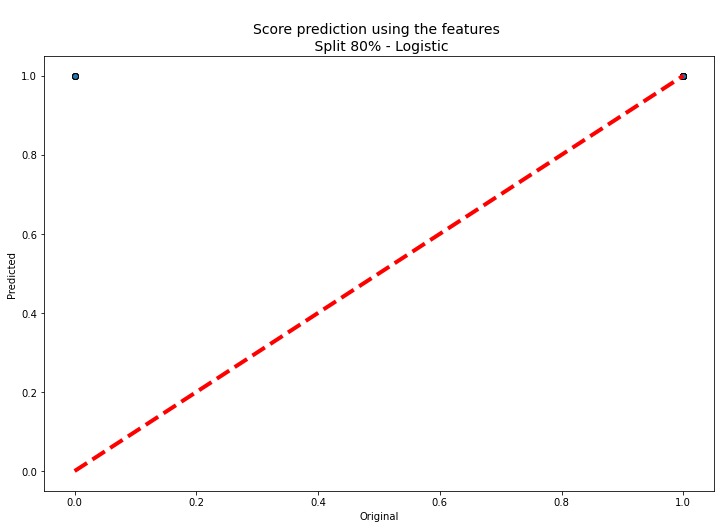

In [174]:
# Plotting the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.title('\nScore prediction using the features \n Split 80% - Logistic', fontsize = 14)
plt.show()

In [ ]:
precision = cross_val_score(logistic, X_train, y_train, cv=10, scoring="precision")
recall = cross_val_score(logistic, X, y, cv=10, scoring="recall")

# Precision: avoid false positives
print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
# Recall: avoid false negatives
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

In [183]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(logistic, X, y, cv=10, method="predict_proba")
# Compute the False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(y, y_pred[:, 1])
# Compute the area under the fpt-tpf curve
auc_score = auc(fpr, tpr)

ValueError: unknown format is not supported

In [185]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Area = {:.5f}".format(auc_score));

NameError: name 'fpr' is not defined

## Task 4
Try to predict the movies feature (rating) with machine learning model.
